# Optimizing with Dominated Novelty Search with Competition-GA in JAX

This notebook demonstrates DNS-GA (Dominated Novelty Search with Competition-GA), an extension of standard DNS that uses evolutionary forecasting to make more informed culling decisions.

## Key Concepts

**Standard DNS** uses dominated novelty: solutions are valued based on their distance to better-performing solutions in behavioral space.

**DNS-GA** extends this with Competition-GA, which:
1. Performs short-term evolutionary forecasting using a mutation-only micro-GA
2. Calculates "future fitness" as max(current_fitness, max_offspring_fitness)
3. Uses future fitness in dominated novelty calculations
4. Operates selectively every `g_n` generations to balance exploration and computation

This enables:
- Better convergence (fewer generations)
- Superior or comparable QD-scores
- Preservation of solutions with high-performing offspring potential

This notebook will show:
- How to set up DNS-GA with Competition-GA
- How to configure the GA forecasting parameters
- How to compare DNS vs DNS-GA performance
- How to visualize the optimization process

## Installation

You will need Python 3.11 or later, and a working JAX installation. For example, you can install JAX with:

Then, install QDax from PyPI:

In [1]:
import os
from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

from qdax.core.dns_ga import DominatedNoveltySearchGA
from qdax.core.dns import DominatedNoveltySearch
import qdax.tasks.brax as environments
from qdax.tasks.brax.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation, polynomial_mutation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from jax.flatten_util import ravel_pytree
from IPython.display import HTML
from brax.io import html

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


## Configuration

Key DNS-GA specific parameters:
- `g_n`: Generation frequency for Competition-GA (1 = every generation, inf = standard DNS)
- `num_ga_children`: Number of offspring per solution in micro-GA (2 recommended)
- `num_ga_generations`: Forecast horizon/depth of GA tree (1-2 recommended)
- `mutation_eta`: Mutation strength for Competition-GA (separate from main emitter)

In [ ]:
# Standard QD parameters
batch_size = 100
env_name = 'walker2d_uni'
episode_length = 100
num_iterations = 1000
seed = 42
policy_hidden_layer_sizes = (64, 64)
iso_sigma = 0.005
line_sigma = 0.05
population_size = 1024
k = 3

# DNS-GA specific parameters
use_competition_ga = True  # Set to False for standard DNS
g_n = 100 # Run Competition-GA every 100 generations
num_ga_children = 2  # Number of children per parent in micro-GA
num_ga_generations = 3  # Depth of GA tree (forecast horizon)
mutation_eta = 0.1  # Mutation strength for Competition-GA
mutation_proportion = 0.01  # Proportion of genes to mutate

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use.

In [3]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)
reset_fn = jax.jit(env.reset)

# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

/Users/briancf/Desktop/source/EvoAlgsAndSwarm/lib-qdax/QDax/.venv/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


## Define the way the policy interacts with the env

Now that the environment and policy has been defined, it is necessary to define a function that describes how the policy must be used to interact with the environment and to store transition data.

In [4]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    env_state,
    policy_params,
    key,
):
    """
    Play an environment step and return the updated state and the transition.
    """
    actions = policy_network.apply(policy_params, env_state.obs)
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and descriptor of each individual.

In [5]:
# Prepare the scoring function
descriptor_extraction_fn = environments.descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter

The emitter is used to evolve the population at each mutation step.

In [6]:
# Define emitter for main evolution loop
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

## Define Competition-GA mutation function

For Competition-GA, we use the same mutation operator as the main emitter (isoline_variation) to ensure consistency and avoid overly aggressive mutations that could produce unrepresentative offspring.

In [7]:
if use_competition_ga:
    # Define mutation function for Competition-GA
    # This function mutates a SINGLE genotype (compatible with vmap)
    def competition_ga_mutation_fn(genotype, key):
        """Mutation function for micro-GA in Competition-GA.
        
        Applies Gaussian mutation (iso noise) to a single genotype.
        Compatible with vmap in Competition-GA implementation.
        """
        # Flatten genotype to count leaves
        genotype_flat, tree_def = jax.tree_util.tree_flatten(genotype)
        num_leaves = len(genotype_flat)
        
        # Split key for each leaf
        keys = jax.random.split(key, num_leaves)
        
        # Reconstruct keys as a tree with same structure as genotype
        keys_tree = jax.tree_util.tree_unflatten(tree_def, keys)
        
        # Apply mutation: add Gaussian noise to each parameter
        def add_noise(x, k):
            return x + jax.random.normal(k, shape=x.shape) * iso_sigma
        
        # Use tree_map to apply mutation with corresponding keys
        mutated = jax.tree_util.tree_map(add_noise, genotype, keys_tree)
        
        return mutated
else:
    competition_ga_mutation_fn = None

## Instantiate and initialise the DNS or DNS-GA algorithm

In [8]:
if use_competition_ga:
    # Instantiate DNS-GA
    algorithm = DominatedNoveltySearchGA(
        scoring_function=scoring_fn,
        emitter=mixing_emitter,
        metrics_function=metrics_function,
        population_size=population_size,
        k=k,
        g_n=g_n,
        num_ga_children=num_ga_children,
        num_ga_generations=num_ga_generations,
        mutation_fn=competition_ga_mutation_fn,
    )
    algo_name = f"DNS-GA (g_n={g_n}, children={num_ga_children}, gens={num_ga_generations})"
else:
    # Instantiate standard DNS
    algorithm = DominatedNoveltySearch(
        scoring_function=scoring_fn,
        emitter=mixing_emitter,
        metrics_function=metrics_function,
        population_size=population_size,
        k=k,
    )
    algo_name = "DNS (Standard)"

print(f"Running: {algo_name}")

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = algorithm.init(init_variables, subkey)

print(f"Initial QD score: {init_metrics['qd_score']:.2f}")
print(f"Initial max fitness: {init_metrics['max_fitness']:.2f}")
print(f"Initial coverage: {init_metrics['coverage']:.2f}")

Running: DNS-GA (g_n=100, children=2, gens=3)
Initial QD score: 22903.10
Initial max fitness: 179.28
Initial coverage: 9.77
Initial QD score: 22903.10
Initial max fitness: 179.28
Initial coverage: 9.77


## Launch iterations

Run the algorithm for the specified number of iterations. If using DNS-GA with g_n > 1, you'll see alternating behavior between fast generations (standard Competition) and slower generations (Competition-GA).

In [9]:
log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
log_filename = "dns-ga-logs.csv" if use_competition_ga else "dns-logs_2.csv"
csv_logger = CSVLogger(
    log_filename,
    header=list(metrics.keys())
)

# Log initial metrics
csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
algorithm_scan_update = algorithm.scan_update

if use_competition_ga:
    # DNS-GA: track generation counter
    generation_counter = 1  # Start at 1 since init is generation 0
    
    for i in range(num_loops):
        start_time = time.time()
        (
            repertoire,
            emitter_state,
            key,
            generation_counter,
        ), current_metrics = jax.lax.scan(
            algorithm_scan_update,
            (repertoire, emitter_state, key, generation_counter),
            (),
            length=log_period,
        )
        timelapse = time.time() - start_time

        # Metrics
        current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
        current_metrics["time"] = jnp.repeat(timelapse, log_period)
        metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

        # Log
        csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Iteration {1+log_period*(i+1)}/{num_iterations} - "
                  f"QD: {metrics['qd_score'][-1]:.2f}, "
                  f"Max Fit: {metrics['max_fitness'][-1]:.2f}, "
                  f"Coverage: {metrics['coverage'][-1]:.2f}")
else:
    # Standard DNS: no generation counter
    for i in range(num_loops):
        start_time = time.time()
        (
            repertoire,
            emitter_state,
            key,
        ), current_metrics = jax.lax.scan(
            algorithm_scan_update,
            (repertoire, emitter_state, key),
            (),
            length=log_period,
        )
        timelapse = time.time() - start_time

        # Metrics
        current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
        current_metrics["time"] = jnp.repeat(timelapse, log_period)
        metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

        # Log
        csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Iteration {1+log_period*(i+1)}/{num_iterations} - "
                  f"QD: {metrics['qd_score'][-1]:.2f}, "
                  f"Max Fit: {metrics['max_fitness'][-1]:.2f}, "
                  f"Coverage: {metrics['coverage'][-1]:.2f}")

print(f"\n{algo_name} completed!")
print(f"Final QD score: {metrics['qd_score'][-1]:.2f}")
print(f"Final max fitness: {metrics['max_fitness'][-1]:.2f}")
print(f"Final coverage: {metrics['coverage'][-1]:.2f}")

Iteration 101/1000 - QD: 306991.91, Max Fit: 210.80, Coverage: 100.00
Iteration 201/1000 - QD: 333879.94, Max Fit: 228.88, Coverage: 100.00
Iteration 201/1000 - QD: 333879.94, Max Fit: 228.88, Coverage: 100.00
Iteration 301/1000 - QD: 345282.25, Max Fit: 240.03, Coverage: 100.00
Iteration 301/1000 - QD: 345282.25, Max Fit: 240.03, Coverage: 100.00
Iteration 401/1000 - QD: 350908.03, Max Fit: 243.25, Coverage: 100.00
Iteration 401/1000 - QD: 350908.03, Max Fit: 243.25, Coverage: 100.00
Iteration 501/1000 - QD: 354470.12, Max Fit: 254.10, Coverage: 100.00
Iteration 501/1000 - QD: 354470.12, Max Fit: 254.10, Coverage: 100.00
Iteration 601/1000 - QD: 358836.06, Max Fit: 264.75, Coverage: 100.00
Iteration 601/1000 - QD: 358836.06, Max Fit: 264.75, Coverage: 100.00
Iteration 701/1000 - QD: 360061.09, Max Fit: 269.45, Coverage: 100.00
Iteration 701/1000 - QD: 360061.09, Max Fit: 269.45, Coverage: 100.00
Iteration 801/1000 - QD: 362241.03, Max Fit: 275.94, Coverage: 100.00
Iteration 801/1000 -

## Visualize results

Plot the evolution of key metrics over time.

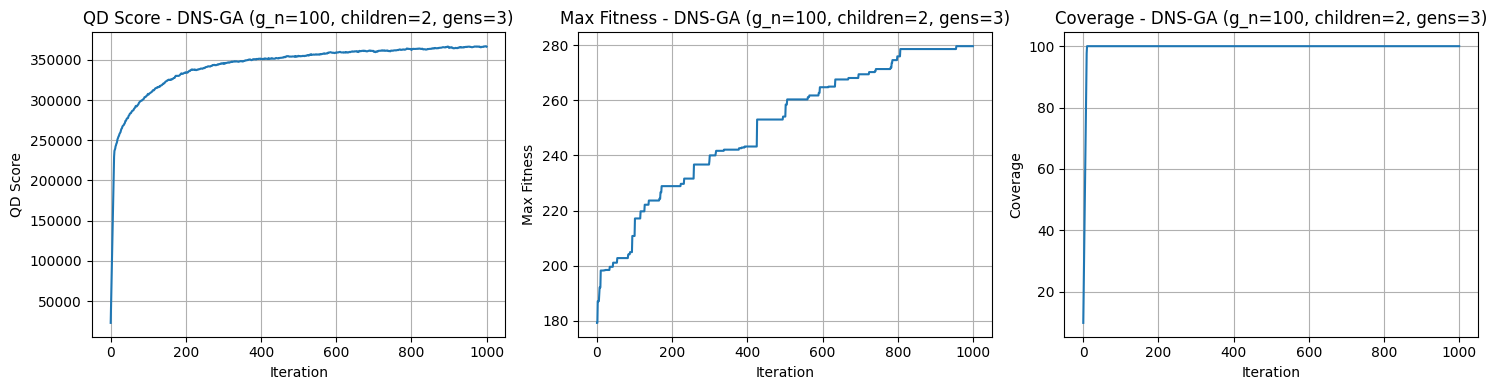

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# QD Score
axes[0].plot(metrics['iteration'], metrics['qd_score'])
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('QD Score')
axes[0].set_title(f'QD Score - {algo_name}')
axes[0].grid(True)

# Max Fitness
axes[1].plot(metrics['iteration'], metrics['max_fitness'])
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Max Fitness')
axes[1].set_title(f'Max Fitness - {algo_name}')
axes[1].grid(True)

# Coverage
axes[2].plot(metrics['iteration'], metrics['coverage'])
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Coverage')
axes[2].set_title(f'Coverage - {algo_name}')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Get the best individual of the repertoire

In [11]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]

print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

Best fitness in the repertoire: 279.64
 Descriptor of the best individual in the repertoire: [0.57 0.41]
 Index in the repertoire of this individual: 657



## Play some steps in the environment

In [12]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy_network.apply)

In [13]:
rollout = []
key, subkey = jax.random.split(key)
state = jit_env_reset(rng=subkey)
list_pipeline_states = []
while not state.done:
    rollout.append(state)
    action = jit_inference_fn(my_params, state.obs)
    state = jit_env_step(state, action)
    list_pipeline_states.append(state.pipeline_state)

print(f"The trajectory of this individual contains {len(rollout)} transitions.")

The trajectory of this individual contains 71 transitions.


In [14]:
def save_rollout_html(env, pipeline_env_list, file_name: str):
    sys = env.sys.tree_replace({'opt.timestep': env.dt})
    rollout_html = html.render(sys, pipeline_env_list)
    with open(file_name, 'w') as f:
        f.write(rollout_html)

rollout_filename = "rollout_dns_ga.html" if use_competition_ga else "rollout_dns.html"
save_rollout_html(env, list_pipeline_states, rollout_filename)
print(f"Rollout saved to {rollout_filename}")

Rollout saved to rollout_dns_ga.html


## Comparison Tips

To compare DNS vs DNS-GA:

1. **Run standard DNS**: Set `use_competition_ga = False` and run the notebook
2. **Run DNS-GA**: Set `use_competition_ga = True` and experiment with:
   - `g_n = 1`: Competition-GA every generation (max exploration, higher computation)
   - `g_n = 5`: Competition-GA every 5 generations (balanced)
   - `g_n = 10`: Competition-GA every 10 generations (more exploitation)
   - `g_n = float('inf')`: Reduces back to standard DNS

3. **Compare metrics**:
   - QD Score: Overall quality-diversity performance
   - Max Fitness: Best solution found
   - Coverage: Diversity of solutions
   - Convergence speed: Iterations to reach performance plateau

4. **Tune GA parameters**:
   - `num_ga_children = 2`: Standard binary offspring
   - `num_ga_generations = 1`: Short-term forecast (less computation)
   - `num_ga_generations = 2`: Medium-term forecast (more computation, potentially better)

Expected results:
- DNS-GA should converge faster (fewer generations)
- DNS-GA should preserve high-quality solutions better
- Computational cost scales with g_n, num_ga_children, and num_ga_generations